In [256]:
import numpy as np

In [257]:
# LabPlt created by Nikita Balagansky. MIPT.
# https://github.com/PUSSYMIPT/labplot
# This Python file uses the following encoding: utf-8

def leastsqr(x, y):
    import numpy as np
    b = (np.mean(x * y) - np.mean(x) * np.mean(y)) /\
        (np.mean(x * x) - np.mean(x) ** 2)
    a = np.mean(y) - b * np.mean(x)
    sig_b = np.sqrt(((np.mean(y ** 2) - np.mean(y) ** 2)/((np.mean(x ** 2) - np.mean(x) ** 2)) - b ** 2)/len(x))
    sig_a = sig_b * (np.mean(x * x) - np.mean(x) ** 2) ** 0.5
    return b, a, sig_b, sig_a


def make_plot(x, y, lab_x='', lab_y='', title='', err_y=None, grid=True,
                y_scale='linear', interpolate_type='RBF', degree=None,
                smooth=True, linear=True, borders=True):
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy.interpolate import Rbf, InterpolatedUnivariateSpline, interpolate, BarycentricInterpolator
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import TheilSenRegressor, Ridge
    left_boarder = min(x) if borders else min(x) - 0.1 * (max(x) - min(x))
    right_boarder = max(x) if borders else max(x) + 0.1 * (max(x) - min(x))
    x1 = np.linspace(left_boarder, right_boarder, 400)
    fig, ax = plt.subplots(figsize=(12, 8))
    plt.xlabel(lab_x)
    plt.ylabel(lab_y)
    plt.grid(grid)
    ax.set_yscale(y_scale)
    ax.errorbar(x, y, yerr=err_y, color='r', label=u'Данные', fmt='.')
    if smooth:
        X_plot = x1[:, np.newaxis]
        flag_model = False
        if interpolate_type == 'RBF':
            smth = Rbf(x, y)
        elif interpolate_type == 'IUS':
            smth = InterpolatedUnivariateSpline(x, y)
        elif interpolate_type == 'cubic':
            smth = interpolate(x, y, kind='cubic', bc_type='natural')
        elif interpolate_type == 'polynomial_r':
            X = x[:, np.newaxis]
            degree = int(degree)
            import warnings
            warnings.filterwarnings(action="ignore", module="scipy",
                                    message="^internal gelsd")
            smth = make_pipeline(PolynomialFeatures(degree),
                                 Ridge(alpha=1*10**-16))
            smth.fit(X, y)
            flag_model = True
        elif interpolate_type == 'polynomial_t':
            X = x[:, np.newaxis]
            degree = int(degree)
            import warnings
            warnings.filterwarnings(action="ignore", module="scipy",
                                    message="^internal gelsd")
            smth = make_pipeline(PolynomialFeatures(degree),
                                 TheilSenRegressor())
            smth.fit(X, y)
            flag_model = True
        else:
            print("Invalid interpolate type: You can choose\
                   RBF, IUS, cubic or polynomial")
            return
        if flag_model:
            y1 = smth.predict(X_plot)
        else:
            y1 = smth(x1)
        plt.plot(x1, y1, color='g', label=u'Сглаживание')
    b1, a1, sig_b1, sig_a1 = leastsqr(x, y)
    label_ = u'\nb={}±{}  a={}±{}'.format(np.round(b1, 3), np.round(sig_b1, 3),
                                          np.round(a1, 3), np.round(sig_a1, 3))
    ax.set_title(title)
    if linear:
        plt.plot(x1, b1 * x1 + a1, label=u'Линейная апроксимация' + label_)
    plt.legend()
    return fig, ax


def make_plots(x_array, y_array, labels, err_y=0, title='', x_label='',
               style='different', y_label='', grid=False, method='cubic',
               degree=1):
    import numpy as np
    from matplotlib import pyplot as plt
    from scipy.interpolate import CubicSpline
    from sklearn.pipeline import make_pipeline
    from sklearn.preprocessing import PolynomialFeatures
    from sklearn.linear_model import LinearRegression, Ridge
    from matplotlib import cm
    fig, ax = plt.subplots(figsize=(12, 8))
    if style == 'blue':
        colors_points = cm.autumn(np.linspace(0, 1, len(x_array)))
        colors_plots = ['b' for i in range(len(x_array))]
    if style == 'different':
        colors_points = cm.tab10(np.linspace(0, 0.49, len(x_array)))
        colors_plots = cm.tab10(np.linspace(0.5, 1, len(x_array)))
    
    if err_y:
        for x, y, c_point, l, c_plot, e_y in zip(x_array, y_array, colors_points,
                                        labels, colors_plots, err_y):
            x_plot = np.linspace(min(x), max(x), 200)
            ax.errorbar(x, y, fmt='o', yerr=e_y, label=l, color=c_point)
            plt.legend()
            if method == 'cubic':
                smth = CubicSpline(x, y)
                y_plot = smth(x_plot)
            elif method == 'polynomial':
                x_pol = x[:, np.newaxis]
                degree = int(degree)
                import warnings
                warnings.filterwarnings(action="ignore", module="scipy",
                                        message="^internal gelsd")
                smth = make_pipeline(PolynomialFeatures(degree),
                                     Ridge(alpha=1*10**-16))
                smth.fit(x_pol, y)
                y_plot = smth.predict(x_plot[:, np.newaxis])
            plt.plot(x_plot, y_plot, color=c_plot)
    else:
        for x, y, c_point, l, c_plot in zip(x_array, y_array, colors_points,
                                        labels, colors_plots):
            x_plot = np.linspace(min(x), max(x), 200)
            ax.errorbar(x, y, fmt='o', yerr=0, label=l, color=c_point)
            plt.legend()
            if method == 'cubic':
                smth = CubicSpline(x, y)
                y_plot = smth(x_plot)
            elif method == 'polynomial':
                x_pol = x[:, np.newaxis]
                degree = int(degree)
                import warnings
                warnings.filterwarnings(action="ignore", module="scipy",
                                        message="^internal gelsd")
                smth = make_pipeline(PolynomialFeatures(degree),
                                     Ridge(alpha=1*10**-16))
                smth.fit(x_pol, y)
                y_plot = smth.predict(x_plot[:, np.newaxis])
            plt.plot(x_plot, y_plot, color=c_plot)
    ax.set_title(title)
    plt.grid(grid)
    plt.xlabel(x_label)
    plt.ylabel(y_label)


def interpolate_values(x, y, method='cubic'):
    from scipy.interpolate import CubicSpline
    import numpy as np
    x_interpolated = np.linspace(min(x), max(x), 500)
    if method == 'cubic':
        smth = CubicSpline(x, y)
        y_interpolated = smth(x_interpolated)
    return x_interpolated, y_interpolated


def find_nearest(array, value):
    import numpy as np
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx


Параметры установки.

In [258]:
t_0 = 9.045
k = 24

Таблица 1.

In [259]:
x1_params = ['T','мкс','мВ']

In [260]:
x1 = np.array([[14.4, 16.12, 18.09, 20, 22.02, 24.02, 26, 28.6, 30.01, 32, 34, 36, 38, 40], 
              [10.77, 10.66, 10.49, 10.31, 9.96, 9.59, 9.43, 9.33, 9.28, 9.25, 9.22, 9.20, 9.19, 9.17], 
              [-0.0035, -0.0033, -0.0056, -0.0141, -0.013, -0.014, -0.016, -0.014, -0.015, -0.016, -0.018, -0.018, -0.018, -0.017]])

Таблица 2.

In [261]:
x2_params = ['T"','мкс','мВ']

In [262]:
temp = x1[0] + x1[2] * k
x2 = np.array([temp, x1[1], x1[2]])

In [263]:
print(x2)

[[ 1.43160e+01  1.60408e+01  1.79556e+01  1.96616e+01  2.17080e+01
   2.36840e+01  2.56160e+01  2.82640e+01  2.96500e+01  3.16160e+01
   3.35680e+01  3.55680e+01  3.75680e+01  3.95920e+01]
 [ 1.07700e+01  1.06600e+01  1.04900e+01  1.03100e+01  9.96000e+00
   9.59000e+00  9.43000e+00  9.33000e+00  9.28000e+00  9.25000e+00
   9.22000e+00  9.20000e+00  9.19000e+00  9.17000e+00]
 [-3.50000e-03 -3.30000e-03 -5.60000e-03 -1.41000e-02 -1.30000e-02
  -1.40000e-02 -1.60000e-02 -1.40000e-02 -1.50000e-02 -1.60000e-02
  -1.80000e-02 -1.80000e-02 -1.80000e-02 -1.70000e-02]]


In [264]:
print(x2[0])

[14.316  16.0408 17.9556 19.6616 21.708  23.684  25.616  28.264  29.65
 31.616  33.568  35.568  37.568  39.592 ]


Погрешность вольтметра: 12 единиц младшего разряда
Постоянная термопары: 14 град/мВ

In [265]:
import matplotlib.pyplot as plt

График 1.

In [266]:
newx = np.array([(i**2 - t_0**2) for i in x2[1]])

Populating the interactive namespace from numpy and matplotlib


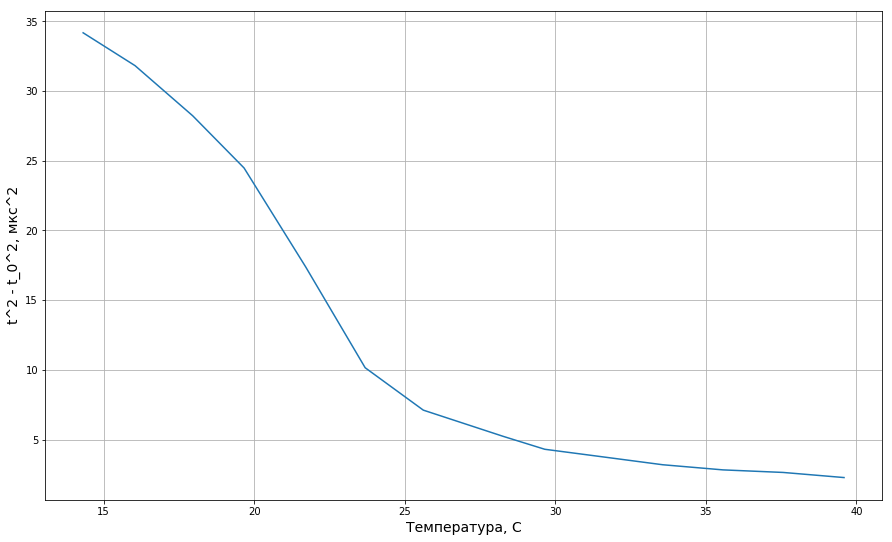

In [267]:
%pylab inline
fig0 = plt.figure(figsize=(15,9))
plt.plot(x2[0], newx)
plt.grid(True)
plt.xlabel('Температура, C', fontsize=14)
plt.ylabel('t^2 - t_0^2, мкс^2', fontsize=14)
plt.show()

График 2.

In [268]:
newx = np.array([1/(i**2 - t_0**2) for i in x2[1]])

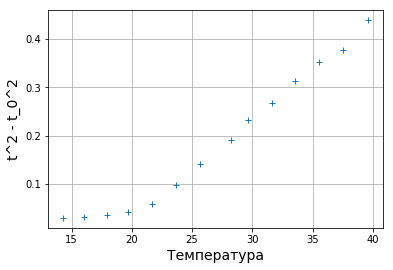

In [269]:
plt.plot(x2[0], newx, '+')
plt.grid(True)
plt.xlabel('Температура', fontsize=14)
plt.ylabel('t^2 - t_0^2', fontsize=14)
plt.show()

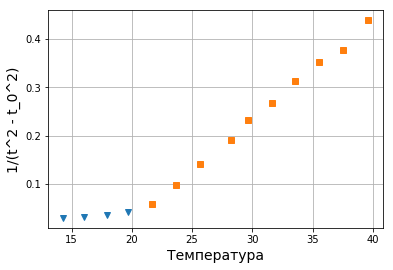

In [270]:
plt.plot(x2[0][:4], newx[:4], 'v')
plt.plot(x2[0][4:], newx[4:], 's')
plt.grid(grid)
plt.xlabel('Температура', fontsize=14)
plt.ylabel('1/(t^2 - t_0^2)', fontsize=14)
plt.show()

Populating the interactive namespace from numpy and matplotlib


(0, 0.45)

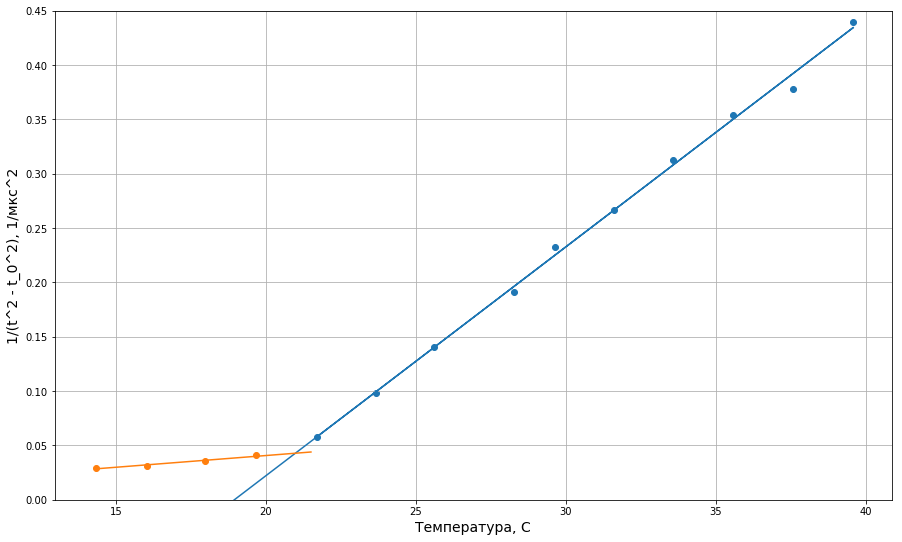

In [290]:
X = [x2[0][4:], x2[0][:4]]
Y = [newx[4:], newx[:4]]

labels = ['', '']

from matplotlib import pyplot as plt
%pylab inline
fig0 = plt.figure(figsize=(15,9))
i = 0
for x, y in zip(X, Y):
    b, a, sigb, siga = leastsqr(x,y)
    plt.scatter(x,y)
    if i:
        x = np.append(x, 21.5)
    else:
        x = np.append(x, 15)
    plt.grid(True)
    plt.xlabel('Температура, C', fontsize=14)
    plt.ylabel('1/(t^2 - t_0^2), 1/мкс^2', fontsize=14)    
    plt.plot(x, x*b + a)
    x = x[:-1]
    i += 1

plt.ylim((0, 0.45))

#make_plots(X, Y, x_label='Температура, C', y_label='1/(t^2 - t_0^2), 1/мкс', labels=labels, method='polynomial', degree=1)

Уравнение синей (слева) прямой:

In [277]:
b1, a1, sig_b1, sig_a1 = leastsqr(x2[0][:4], newx[:4])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.0021577865661618015 -0.0024313534581420423 0.00020525595558378566 0.00041206171568361954


Уравнение коричневой (справа) прямой:

In [278]:
b1, a1, sig_b1, sig_a1 = leastsqr(x2[0][4:], newx[4:])
# y = bx + a
print(b1, a1, sig_b1, sig_a1)

0.021043228746893544 -0.3986551751180013 0.00031880306615169576 0.0018089376150399372


Точка пересечения с Ох: 0 = 0.021x -0.399

In [285]:
x = 0.3986551751180013/0.021043228746893544

In [286]:
x

18.944582122496378

In [287]:
(0.319**2 + 1.81**2)**0.5

1.837895807710546

In [288]:
1.83/18.9

0.09682539682539684